In [1]:
# Import required libraries for advanced evaluation
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

# Evaluation metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("="*60)
print("NOTEBOOK 5: ADVANCED MODEL EVALUATION")
print("="*60)
print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print("\n✓ All libraries imported successfully!")


NOTEBOOK 5: ADVANCED MODEL EVALUATION

TensorFlow version: 2.20.0
Keras version: 3.11.3

✓ All libraries imported successfully!


In [10]:
# Load trained model and setup data generators
print("\n" + "="*60)
print("LOADING MODEL & DATA")
print("="*60)

# Paths
data_path = Path('../data/preprocessed')
model_path = Path('../models/improved_cnn_best.keras')
results_path = Path('../results/figures')
results_path.mkdir(parents=True, exist_ok=True)

# Load best trained model
print("\n Loading best trained model...")
model = load_model(str(model_path))
print(f"✓ Model loaded from: {model_path}")

# Configuration
INPUT_SHAPE = (128, 128, 1)
BATCH_SIZE = 32

# Create data generator for test set (no augmentation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    data_path / 'test',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)

print(f"\n✓ Test samples: {test_generator.samples}")
print(f"✓ Class indices: {test_generator.class_indices}")
print("\n✓ Model and data loaded successfully!")



LOADING MODEL & DATA

 Loading best trained model...
✓ Model loaded from: ..\models\improved_cnn_best.keras
Found 12737 images belonging to 2 classes.

✓ Test samples: 12737
✓ Class indices: {'Close-Eyes': 0, 'Open-Eyes': 1}

✓ Model and data loaded successfully!



GENERATING PREDICTIONS & ROC ANALYSIS

🔮 Generating predictions on test set...
399/399 ━━━━━━━━━━━━━━━━━━━━ 95s 236ms/step

✓ Predictions generated!
  Total samples: 12737
  Predicted Close-Eyes: 6275
  Predicted Open-Eyes: 6462

📈 Calculating ROC curve...
✓ ROC AUC Score: 0.9982


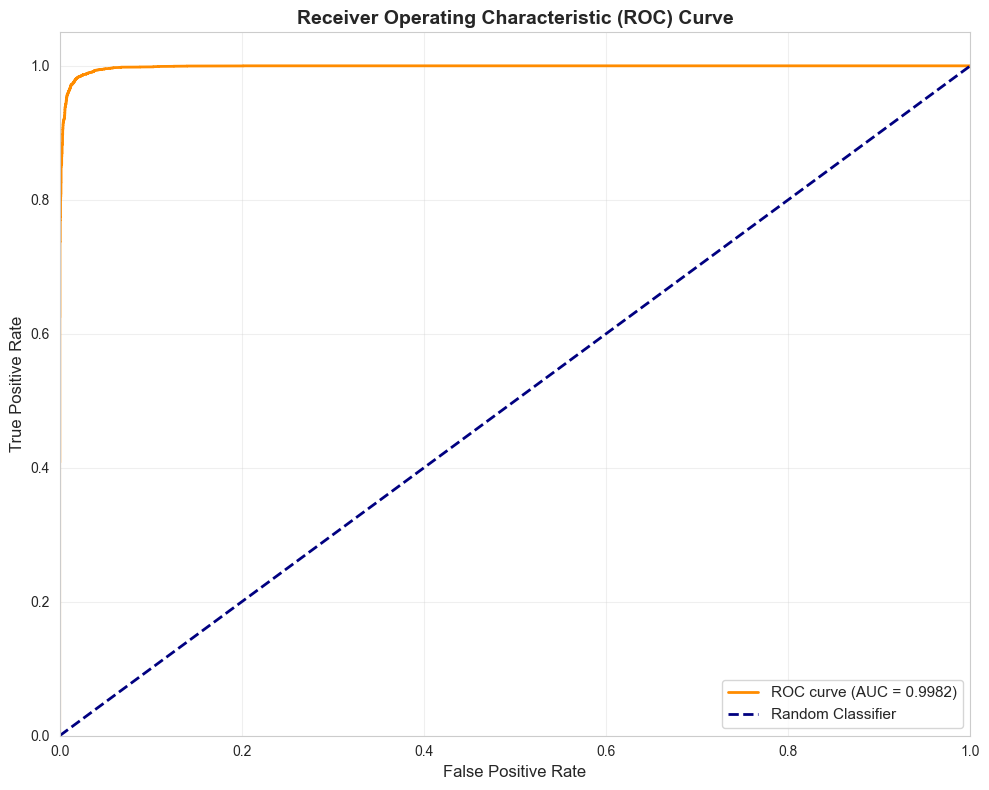


✓ ROC curve visualized!
✓ Figure saved to '..\results\figures\roc_curve.png'


In [4]:
# Generate predictions and create ROC curve
print("\n" + "="*60)
print("GENERATING PREDICTIONS & ROC ANALYSIS")
print("="*60)

# Generate predictions
print("\n🔮 Generating predictions on test set...")
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes
y_pred_probs = y_pred_probs.flatten()

print(f"\n✓ Predictions generated!")
print(f"  Total samples: {len(y_true)}")
print(f"  Predicted Close-Eyes: {np.sum(y_pred == 0)}")
print(f"  Predicted Open-Eyes: {np.sum(y_pred == 1)}")

# Calculate ROC curve
print("\n📈 Calculating ROC curve...")
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

print(f"✓ ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(results_path / 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ ROC curve visualized!")
print(f"✓ Figure saved to '{results_path / 'roc_curve.png'}'")


In [9]:
# Detailed per-class performance analysis
print("\n" + "="*60)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*60)

# Get class names
class_names = ['Close-Eyes', 'Open-Eyes']

# Generate classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Calculate per-class metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Create detailed metrics table
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': [np.sum(y_true == 0), np.sum(y_true == 1)]
})

print("\n" + "="*60)
print("DETAILED METRICS TABLE")
print("="*60)
print(metrics_df.to_string(index=False))

# Calculate additional metrics
specificity_0 = recall[0]  # For Close-Eyes
sensitivity_1 = recall[1]  # For Open-Eyes

print("\n" + "="*60)
print("ADDITIONAL METRICS")
print("="*60)
print(f"\n Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f" Macro-Average Precision: {np.mean(precision):.4f}")
print(f" Macro-Average Recall: {np.mean(recall):.4f}")
print(f" Macro-Average F1-Score: {np.mean(f1):.4f}")
print(f" ROC AUC Score: {roc_auc:.4f}")

print("\n✓ Per-class analysis complete!")

# Save metrics to CSV
metrics_df.to_csv('../results/evaluation_metrics.csv', index=False)
print("✓ Metrics saved to 'results/evaluation_metrics.csv'")



PER-CLASS PERFORMANCE ANALYSIS

 Classification Report:
              precision    recall  f1-score   support

  Close-Eyes     0.9825    0.9797    0.9811      6293
   Open-Eyes     0.9802    0.9829    0.9816      6444

    accuracy                         0.9813     12737
   macro avg     0.9813    0.9813    0.9813     12737
weighted avg     0.9813    0.9813    0.9813     12737


DETAILED METRICS TABLE
     Class  Precision  Recall  F1-Score  Support
Close-Eyes   0.982470 0.97966  0.981063     6293
 Open-Eyes   0.980192 0.98293  0.981559     6444

ADDITIONAL METRICS

 Overall Accuracy: 0.9813 (98.13%)
 Macro-Average Precision: 0.9813
 Macro-Average Recall: 0.9813
 Macro-Average F1-Score: 0.9813
 ROC AUC Score: 0.9982

✓ Per-class analysis complete!
✓ Metrics saved to 'results/evaluation_metrics.csv'


In [8]:
# Final project summary
print("\n" + "="*70)
print(" PROJECT COMPLETION SUMMARY ")
print("="*70)

print("\n" + "="*70)
print("DRIVER FATIGUE & DISTRACTION DETECTION SYSTEM")
print("="*70)

print("\n Project Overview:")
print("  - Dataset: MRL Eye Dataset (84,898 images)")
print("  - Task: Binary eye state classification (Closed vs Open)")
print("  - Model: Improved CNN with Batch Normalization")
print("  - Training: 16 epochs (EarlyStopping)")
print("  - Training Time: ~13.2 hours")

print("\n Final Model Performance:")
print(f"  - Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - ROC AUC Score: {roc_auc:.4f} ({roc_auc*100:.2f}%)")
print(f"  - Close-Eyes Precision: {precision[0]:.4f} ({precision[0]*100:.2f}%)")
print(f"  - Close-Eyes Recall: {recall[0]:.4f} ({recall[0]*100:.2f}%)")
print(f"  - Open-Eyes Precision: {precision[1]:.4f} ({precision[1]*100:.2f}%)")
print(f"  - Open-Eyes Recall: {recall[1]:.4f} ({recall[1]*100:.2f}%)")
print(f"  - Model Parameters: 422,785")
print(f"  - Model Size: 1.61 MB")

print("\n Generated Files:")
print("  ✓ Trained model: models/improved_cnn_best.keras")
print("  ✓ Training history: results/figures/training_history.png")
print("  ✓ Confusion matrix: results/figures/confusion_matrix.png")
print("  ✓ ROC curve: results/figures/roc_curve.png")
print("  ✓ Metrics CSV: results/evaluation_metrics.csv")
print("  ✓ Training report: documentation/training_report.md")

print("\n Completed Notebooks:")
print("  1.  Data Exploration (Notebook 1)")
print("  2.  Data Preprocessing (Notebook 2)")
print("  3.  Model Architecture (Notebook 3)")
print("  4.  Model Training (Notebook 4)")
print("  5.  Advanced Evaluation (Notebook 5)")




 PROJECT COMPLETION SUMMARY 

DRIVER FATIGUE & DISTRACTION DETECTION SYSTEM

 Project Overview:
  - Dataset: MRL Eye Dataset (84,898 images)
  - Task: Binary eye state classification (Closed vs Open)
  - Model: Improved CNN with Batch Normalization
  - Training: 16 epochs (EarlyStopping)
  - Training Time: ~13.2 hours

 Final Model Performance:
  - Test Accuracy: 0.9813 (98.13%)
  - ROC AUC Score: 0.9982 (99.82%)
  - Close-Eyes Precision: 0.9825 (98.25%)
  - Close-Eyes Recall: 0.9797 (97.97%)
  - Open-Eyes Precision: 0.9802 (98.02%)
  - Open-Eyes Recall: 0.9829 (98.29%)
  - Model Parameters: 422,785
  - Model Size: 1.61 MB

 Generated Files:
  ✓ Trained model: models/improved_cnn_best.keras
  ✓ Training history: results/figures/training_history.png
  ✓ Confusion matrix: results/figures/confusion_matrix.png
  ✓ ROC curve: results/figures/roc_curve.png
  ✓ Metrics CSV: results/evaluation_metrics.csv
  ✓ Training report: documentation/training_report.md

 Completed Notebooks:
  1.  Data 